In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

In [2]:
df = pd.read_csv(r"D:\Metta's File\Portfolio\1_Fraud_detection\onlinefraud.csv")

# Dataset source: https://www.kaggle.com/datasets/jainilcoder/online-payment-fraud-detection

# 1. EDA and Feature Engineering

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
df.shape

(6362620, 11)

In [10]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### Plots

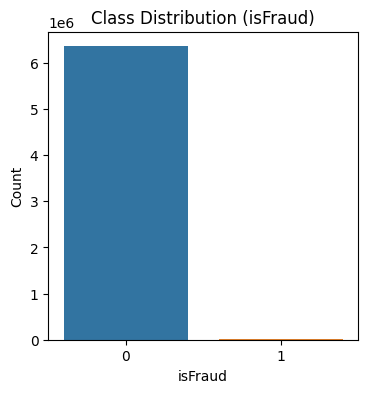

% of Fraud Transactions: 0.12908204481801522
% of Non-Fraud Transactions: 99.87091795518198


In [11]:
# Target Variable ---------------------------------
# Count number of fraud and non-fraud transactions
fraud_counts = df['isFraud'].value_counts()

# Plot
plt.figure(figsize=(4, 4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title('Class Distribution (isFraud)')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.show()

# Display distribution
print("% of Fraud Transactions:", (fraud_counts[1] / len(df)) * 100)
print("% of Non-Fraud Transactions:", (fraud_counts[0] / len(df)) * 100)

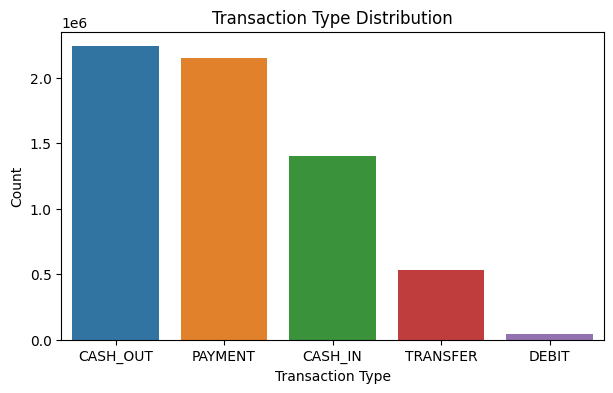

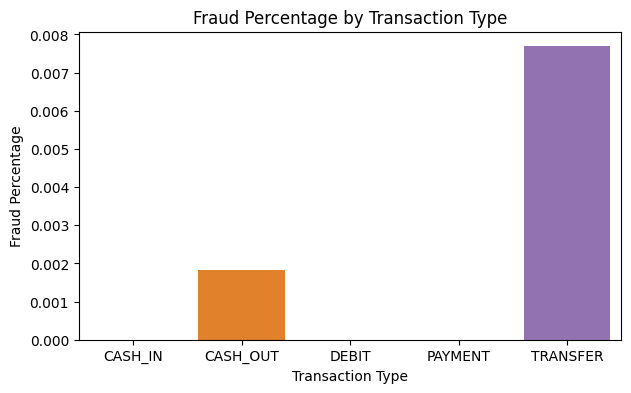

In [12]:
# Transaction Type ----------------------------------
type_counts = df['type'].value_counts()

# Plot transaction type distribution
plt.figure(figsize=(7, 4))
sns.barplot(x=type_counts.index, y=type_counts.values)
plt.title('Transaction Type Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

# Check fraud distribution by transaction type
fraud_by_type = df.groupby('type')['isFraud'].mean().reset_index()

# Plot fraud percentage by transaction type
plt.figure(figsize=(7, 4))
sns.barplot(x='type', y='isFraud', data=fraud_by_type)
plt.title('Fraud Percentage by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Percentage')
plt.show()

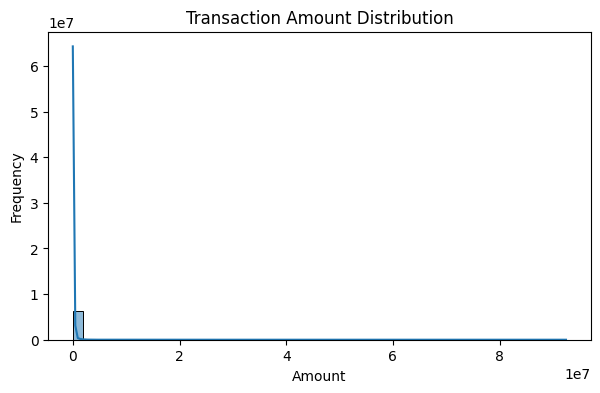

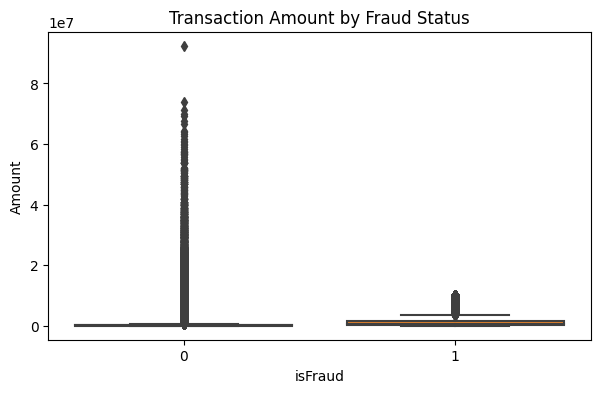

In [13]:
# Amount ---------------------------------------
# Plot the distribution of amounts
plt.figure(figsize=(7, 4))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

# Compare amounts for fraud and non-fraud 
plt.figure(figsize=(7, 4))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('isFraud')
plt.ylabel('Amount')
plt.show()

#### Correlation Matrix

In [14]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns (e.g., 'type')
df['type_encoded'] = label_encoder.fit_transform(df['type'])
df['nameOrig_encoded'] = label_encoder.fit_transform(df['nameOrig'])
df['nameDest_encoded'] = label_encoder.fit_transform(df['nameDest'])

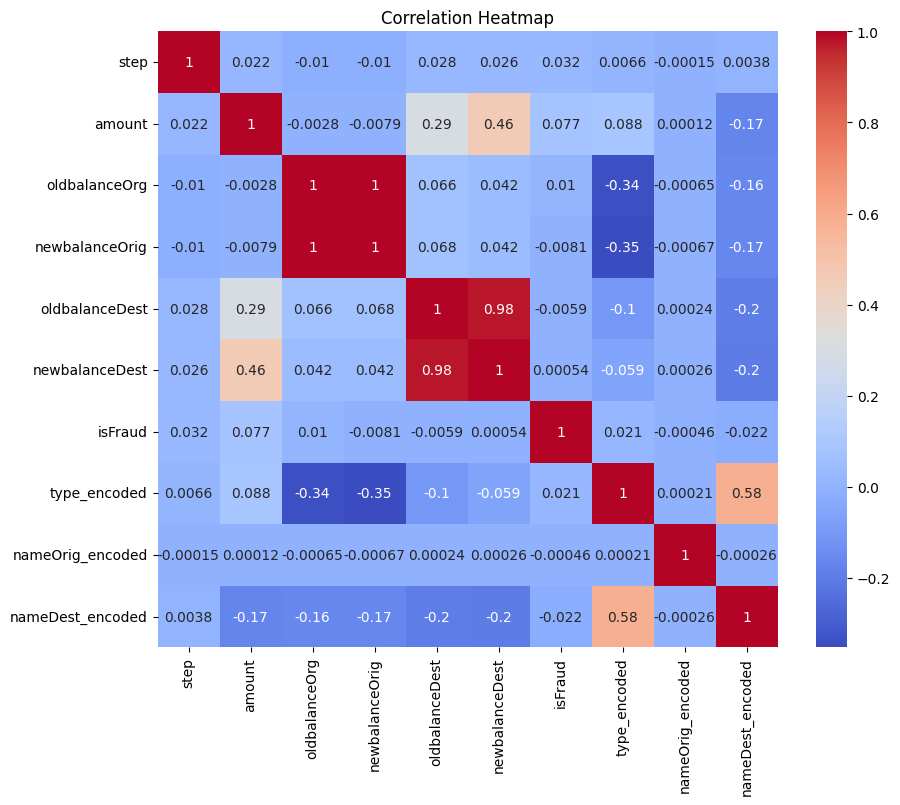

In [15]:
df_encoded = df.drop(['isFlaggedFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
corr_matrix = df_encoded.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [16]:
# The EDA showed that there are no missing values in the data. However the data contains 99% of non-fraud data. 
# Thus, class balancing needs to be done to ensure model effectiveness.

# 2. Train and Test Set Preparation

In [3]:
# features for train and test set
X = df.drop(['isFraud', 'isFlaggedFraud','type', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

In [4]:
from sklearn.model_selection import train_test_split

# Split  data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check the class distribution in the training set
print("Train Set Distribution:")
print(y_train.value_counts())

# Check the class distribution in the test set
print("Test Set Distribution:")
print(y_test.value_counts())

Train Set Distribution:
isFraud
0    4448056
1       5778
Name: count, dtype: int64
Test Set Distribution:
isFraud
0    1906351
1       2435
Name: count, dtype: int64


#### Class Balancing
Executed on the train set only to ensures the test set results simulates real world scenario and keep the evaluation results fair.

In [5]:
# SMOTE Method -- 60/40 is chosen to minimize possibility of overfitting and reduce false positives.
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy= 0.67, random_state=7)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Train Set Distribution:" , y_train_resampled.value_counts())

Train Set Distribution: isFraud
0    4448056
1    2980197
Name: count, dtype: int64


In [6]:
# # SMOTEENN (SMOTE + Edited Nearest Neighbors)
# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# # Check the new class distribution
# print("Resampled Class Distribution:", y_resampled.value_counts())

# 3. Model Builds

## Classification Models for Fraud Detection
In the classification model, multiple ML Classification algorithms are used to see which model can give the best performance to detect frauds in the data.

In [7]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve

##### a. Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

# Initialize and train 
lr_model = LogisticRegression(max_iter=1000, random_state=100) #class_weight='balanced'
lr_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

In [9]:
# Evaluate model
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99   1906351
           1       0.04      0.85      0.08      2435

    accuracy                           0.97   1908786
   macro avg       0.52      0.91      0.53   1908786
weighted avg       1.00      0.97      0.99   1908786

ROC-AUC Score: 0.9710494589857053


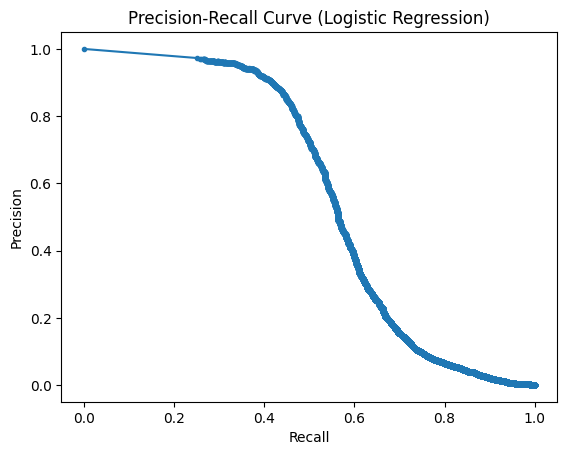

In [10]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lr)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Logistic Regression)')
plt.show()

##### b. Decision Tree 

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train
dt_model = DecisionTreeClassifier(random_state=100) #class_weight='balanced'
dt_model.fit(X_train_resampled, y_train_resampled)

# predict
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Evaluate 
print("Decision Tree Results:")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_dt))

Decision Tree Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.62      0.93      0.75      2435

    accuracy                           1.00   1908786
   macro avg       0.81      0.97      0.87   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC Score: 0.9663760499935814


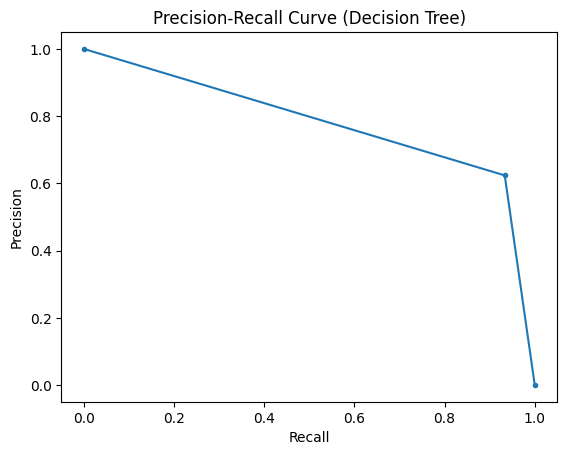

In [12]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_dt)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Decision Tree)')
plt.show()

##### c. Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf_model = RandomForestClassifier(n_estimators = 50, max_depth= 1000, n_jobs=-1, random_state=100) #class_weight='balanced'
rf_model.fit(X_train_resampled, y_train_resampled)

# predict
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.57      0.92      0.71      2435

    accuracy                           1.00   1908786
   macro avg       0.79      0.96      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC Score: 0.9959810416998035


In [16]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1000,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}

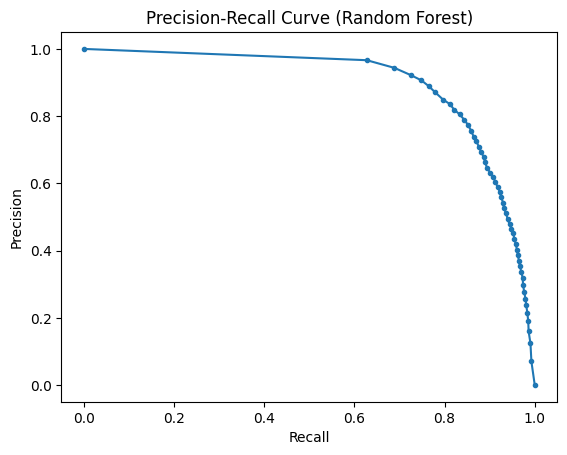

In [15]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_rf)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Random Forest)')
plt.show()

##### d. XG Boost

In [19]:
from xgboost import XGBClassifier

# Initialize and train the model
xgb_model = XGBClassifier(max_depth= 4, n_jobs=-1, random_state=100)  
#scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_xgb))

XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906351
           1       0.15      0.99      0.26      2435

    accuracy                           0.99   1908786
   macro avg       0.57      0.99      0.63   1908786
weighted avg       1.00      0.99      1.00   1908786

ROC-AUC Score: 0.9980737325449943


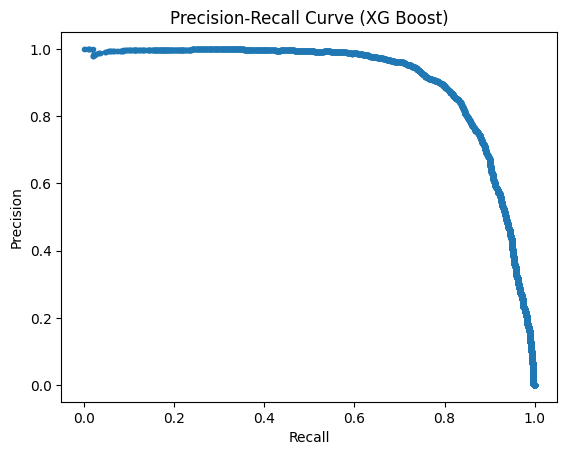

In [20]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XG Boost)')
plt.show()

##### e. Comparisons

In [ ]:
# Since the dataset is imbalanced, the model evaluation is done with:
# - Precision, Recall, and F1 metrics.
# - ROC - AUC Score
# - Precision Recall Curve (PRC)

In [21]:
models = {
    'Logistic Regression': y_pred_lr,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb
}

probas = {
    'Logistic Regression': y_pred_proba_lr,
    'Decision Tree': y_pred_proba_dt,
    'Random Forest': y_pred_proba_rf,
    'XGBoost': y_pred_proba_xgb
}

results = []

for model, preds in models.items():
    report = classification_report(y_test, preds, output_dict=True)['1']
    results.append({
        'Model': model,
        'Recall': report['recall'],
        'Precision': report['precision'],
        'F1-Score': report['f1-score'],
        'ROC-AUC': roc_auc_score(y_test, probas[model])
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Model    Recall  Precision  F1-Score   ROC-AUC
0  Logistic Regression  0.850924   0.041523  0.079182  0.971049
1        Decision Tree  0.933470   0.624108  0.748066  0.966376
2        Random Forest  0.922793   0.574827  0.708386  0.995981
3              XGBoost  0.989322   0.147493  0.256714  0.998074


In [22]:
from sklearn.metrics import confusion_matrix

#confusion matrix for all the models
# Compute confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr).ravel()
cm_dt = confusion_matrix(y_test, y_pred_dt).ravel()
cm_rf = confusion_matrix(y_test, y_pred_rf).ravel()
cm_xgb = confusion_matrix(y_test, y_pred_xgb).ravel()

result_details = pd.DataFrame({
    'Model': ['LR', 'DT', 'RF', 'XGB'],
    'TN': [cm_lr[0], cm_dt[0], cm_rf[0], cm_xgb[0]],
    'FP': [cm_lr[1], cm_dt[1], cm_rf[1], cm_xgb[1]],
    'FN': [cm_lr[2], cm_dt[2], cm_rf[2], cm_xgb[2]],
    'TP': [cm_lr[3], cm_dt[3], cm_rf[3], cm_xgb[3]]
})

result_details

,Model,TN,FP,FN,TP
0,LR,1858523,47828,363,2072
1,DT,1904982,1369,162,2273
2,RF,1904689,1662,188,2247
3,XGB,1892427,13924,26,2409


##### f. Conclusions

######
Results from the 4 models shows RF and XGB has the highest ROC-AUC score amongst the others, >99%.
Choosing one from the other has its own advantages and disadvantages.

RF Model
- Significantly less False Positives
- A higher amount of False Negatives, thus more chances for a fraud event to go unflagged.

XGB Model
- Very high amount of False Positives, which may lead to ineffective alerts for stakeholders.
- Low amount of False Negative, therefore there are less fraud events that go undetected.

## Utilizing Anomaly Detection Model to Determine the Outcome 
Next, we experimented with Isolation Forest to simulate situation where the target variable is not present. This is to mimic situations in real life conditions where usually ground truth is not present to be used for the data to be trained.

In [24]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=100, 
    contamination=0.01,  # Proportion of anomalies (data used: 1%)
    random_state=100
)

# Train the model on the training data
iso_forest.fit(X_train_resampled)

IsolationForest(contamination=0.01, random_state=100)

In [28]:
#predidct
y_pred_iso = iso_forest.predict(X_test)

#Convert predictions to binary labels (0 for normal, 1 for fraud)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

In [34]:
# Evaluate the model
print("Isolation Forest Results:\n", classification_report(y_test, y_pred_iso))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_iso)
print("Confusion Matrix:\n",cm)

# ROC-AUC Score requires probability scores -- Isolation Forest does not provide directly
# alternative: use the decision_function to get anomaly scores
anomaly_scores = iso_forest.decision_function(X_test)
print("ROC-AUC Score:", roc_auc_score(y_test, -anomaly_scores))  # Negative sign because lower scores indicate anomalies

Isolation Forest Results:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99   1906351
           1       0.00      0.01      0.00      2435

    accuracy                           0.99   1908786
   macro avg       0.50      0.50      0.50   1908786
weighted avg       1.00      0.99      0.99   1908786

Confusion Matrix:
 [[1888517   17834]
 [   2399      36]]
ROC-AUC Score: 0.6449533515785462


C:\Users\metta\AppData\Local\Temp\ipykernel_16268\1668895208.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(-anomaly_scores, bins=50, kde=True, palette='coolwarm')


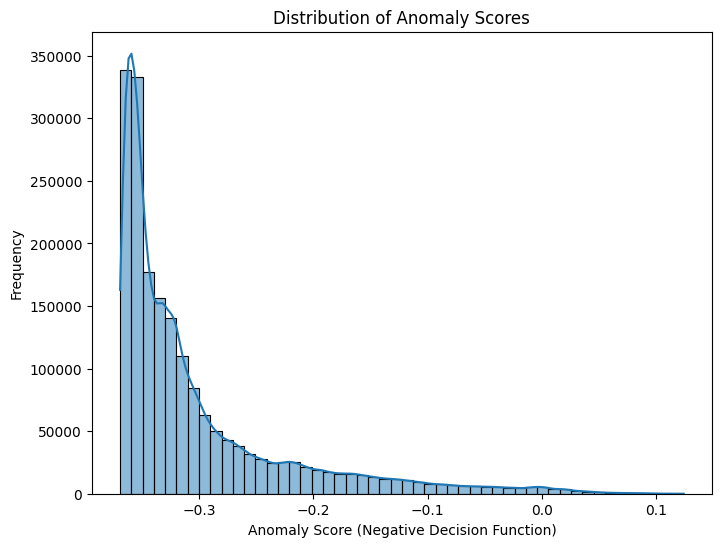

In [33]:
# Plot the distribution 
plt.figure(figsize=(8, 6))
sns.histplot(-anomaly_scores, bins=50, kde=True, palette='coolwarm')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score (Negative Decision Function)')
plt.ylabel('Frequency')
plt.show()

# Summary

In [35]:
models = {
    'Logistic Regression': y_pred_lr,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Isolation Forest': y_pred_iso
}

probas = {
    'Logistic Regression': y_pred_proba_lr,
    'Decision Tree': y_pred_proba_dt,
    'Random Forest': y_pred_proba_rf,
    'XGBoost': y_pred_proba_xgb,
    'Isolation Forest': -anomaly_scores
}

results = []

for model, preds in models.items():
    report = classification_report(y_test, preds, output_dict=True)['1']
    results.append({
        'Model': model,
        'Recall': report['recall'],
        'Precision': report['precision'],
        'F1-Score': report['f1-score'],
        'ROC-AUC': roc_auc_score(y_test, probas[model])
    })

results_df = pd.DataFrame(results)
results_df

,Model,Recall,Precision,F1-Score,ROC-AUC
0,Logistic Regression,0.850924,0.041523,0.079182,0.971049
1,Decision Tree,0.933470,0.624108,0.748066,0.966376
2,Random Forest,0.922793,0.574827,0.708386,0.995981
3,XGBoost,0.989322,0.147493,0.256714,0.998074
4,Isolation Forest,0.014784,0.002015,0.003546,0.644953


In [37]:
# add iForest data to the Confusion Matrix table

cm_iso = confusion_matrix(y_test, y_pred_iso).ravel()

result_details = pd.DataFrame({
    'Model': ['LR', 'DT', 'RF', 'XGB', 'IF'],
    'TN': [cm_lr[0], cm_dt[0], cm_rf[0], cm_xgb[0], cm_iso[0]],
    'FP': [cm_lr[1], cm_dt[1], cm_rf[1], cm_xgb[1], cm_iso[1]],
    'FN': [cm_lr[2], cm_dt[2], cm_rf[2], cm_xgb[2], cm_iso[2]],
    'TP': [cm_lr[3], cm_dt[3], cm_rf[3], cm_xgb[3], cm_iso[3]],
    'Type': ['Classification', 'Classification','Classification','Classification', 'Anomaly Detection']
})

result_details

,Model,TN,FP,FN,TP,Type
0,LR,1858523,47828,363,2072,Classification
1,DT,1904982,1369,162,2273,Classification
2,RF,1904689,1662,188,2247,Classification
3,XGB,1892427,13924,26,2409,Classification
4,IF,1888517,17834,2399,36,Anomaly Detection


######
The anomaly detection model result shows that without any target variable data for reference, the algorithm is able to classify fraudulent / non-fraudulent transactions with an adequate performance, although at a much lower level versus the trained classification model.

In a real life scenario where ground truth data may not be present, this experiment can serve as a proof of concept on how results may be given with models developed with no ground truth. 

Flagged events from real life True Positives may have different patterns across different problems and domains. Depending on how the Anomaly Detection model is adjusted and tuned, the Anomaly Detection based model may be able to yield results similar as the trained classification model.
